In [1]:
import numpy as np
import os

## Loading Images and GT Masks

In [2]:
train_path = "/kaggle/input/lidc-hpunet/train"
val_path = "/kaggle/input/lidc-hpunet/val"
test_path = "/kaggle/input/lidc-hpunet/test"

In [3]:
data_paths = {}

for split in ["train", "val", "test"]:
    # Loading images
    image_dir = f"/kaggle/input/lidc-hpunet/{split}/images"
    nodules = sorted(os.listdir(image_dir))
    
    nodule_paths = []
    image_paths = []
    
    for nodule in nodules:
        nodule_paths.append(os.path.join(image_dir, nodule))
    for nod_path in nodule_paths:
        images = sorted(os.listdir(nod_path))
        for img in images:
            image_paths.append(os.path.join(nod_path, img))

    # Loading masks
    gt_dir = f"/kaggle/input/lidc-hpunet/{split}/gt"
    
    nodules = sorted(os.listdir(gt_dir))
    nodule_paths = []
    gt_paths = []
    
    for nodule in nodules:
        nodule_paths.append(os.path.join(gt_dir, nodule))
        
    for nod_path in nodule_paths:
        gts = sorted(os.listdir(nod_path))
        for gt in gts:
            gt_paths.append(os.path.join(nod_path, gt))

    rows = len(image_paths)
    columns = 4
    gt_arranged_paths = [gt_paths[i * columns : (i+1) * columns] for i in range(rows)]

    data_paths[split] = {"image_paths": image_paths, "gt_paths": gt_arranged_paths}
    

In [4]:
train_paths = data_paths["train"]
train_image_paths = train_paths["image_paths"]
train_gt_paths = train_paths["gt_paths"]

In [5]:
val_paths = data_paths["val"]
val_image_paths = val_paths["image_paths"]
val_gt_paths = val_paths["gt_paths"]

In [6]:
test_paths = data_paths["test"]
test_image_paths = test_paths["image_paths"]
test_gt_paths = test_paths["gt_paths"]

In [7]:
print(len(train_image_paths))
print(len(train_gt_paths))

8843
8843


In [8]:
print(len(val_image_paths))
print(len(val_gt_paths))

1993
1993


In [9]:
print(len(test_image_paths))
print(len(test_gt_paths))

1980
1980


In [10]:
train_gt_paths[0]

['/kaggle/input/lidc-hpunet/train/gt/LIDC-IDRI-0001/z-105.0_c0_l0.png',
 '/kaggle/input/lidc-hpunet/train/gt/LIDC-IDRI-0001/z-105.0_c0_l1.png',
 '/kaggle/input/lidc-hpunet/train/gt/LIDC-IDRI-0001/z-105.0_c0_l2.png',
 '/kaggle/input/lidc-hpunet/train/gt/LIDC-IDRI-0001/z-105.0_c0_l3.png']

In [11]:
train_image_paths[0]

'/kaggle/input/lidc-hpunet/train/images/LIDC-IDRI-0001/z-105.0_c0.png'

In [12]:
type(train_gt_paths)

list

## Libraries

In [13]:
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Plotting the Image and GT Masks

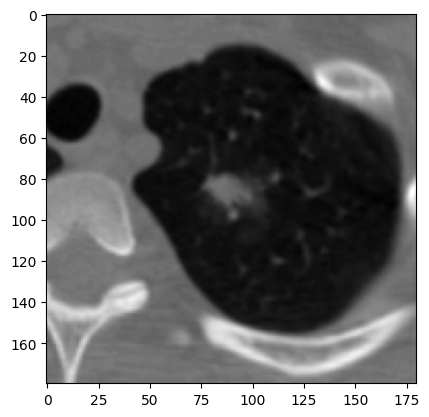

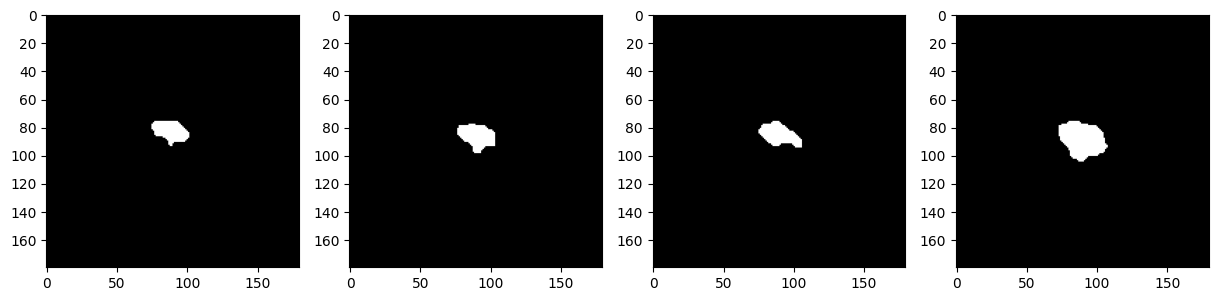

In [14]:
ex_idx = 196

ex_img_path = train_image_paths[ex_idx]
ex_gt_paths = train_gt_paths[ex_idx]

img = Image.open(ex_img_path)
plt.imshow(img, cmap='gray')
plt.show()

fig, axes = plt.subplots(1, 4, figsize=(15,5))
idx = 0
for ex_gt_path in ex_gt_paths:
    gt = Image.open(ex_gt_path)
    axes[idx].imshow(gt, cmap='gray')
    idx = idx+1
plt.show()

In [15]:
print(f"Height and Width of Image is {img.size}")
print(f"Height and Width of GT mask is {gt.size}")

Height and Width of Image is (180, 180)
Height and Width of GT mask is (180, 180)


In [16]:
img.mode          # image mode L means it's a grayscale image. channel = 1

'L'

In [17]:
gt.mode

'L'

## Preprocess

In [18]:
train_preprocess = A.Compose([
    A.RandomCrop(width=128, height=128),
    A.OneOf([
        A.HorizontalFlip(p=0.3),
        A.VerticalFlip(p=0.2)
    ]),
    A.RandomBrightnessContrast(p=0.2),
    A.OneOf([
        A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=1)
    ], p=0.8),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

<ipython-input-18-ac00e53e810a>:9: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),


In [19]:
preprocess = A.Compose([
    A.RandomCrop(width=128, height=128),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

## Dataset Dataloader

In [20]:
class LIDCsegment(Dataset):
    def __init__(self, image, transform, gt=None):
        self.image = image
        self.gt = gt
        self.transform = transform
    def __len__(self):
        return len(self.image)
    def __getitem__(self, idx):
        image = Image.open(self.image[idx])
        image = np.array(image)
        
        if self.gt is not None:
            gt_idx = torch.randint(0, 4, (1,)).item()
            gt_mask = Image.open(self.gt[idx][gt_idx])
            gt_mask = np.array(gt_mask)
            
            transformed = self.transform(image=image, mask=gt_mask)
            transformed_img = transformed["image"]
            transformed_mask = transformed["mask"]

            transformed_mask = torch.unsqueeze(transformed_mask, dim=0)
            return transformed_img, transformed_mask
            
        else:
            transformed = self.transform(image=image)
            transformed_img = transformed["image"]
            return transformed_img

In [21]:
train_dataset = LIDCsegment(image=train_image_paths, transform=train_preprocess, gt=train_gt_paths)
val_dataset = LIDCsegment(image=val_image_paths, transform=preprocess)
test_dataset = LIDCsegment(image=test_image_paths, transform=preprocess)

### Hyperparameters

In [22]:
BATCH_SIZE = 32
EPOCHS = 10
LR = 0.001

In [23]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [25]:
image, mask = next(iter(train_loader))

In [26]:
print(len(image))
print(type(image))
print(image.shape)
print("void")
print(len(mask))
print(type(mask))
print(mask.shape)

32
<class 'torch.Tensor'>
torch.Size([32, 1, 128, 128])
void
32
<class 'torch.Tensor'>
torch.Size([32, 1, 128, 128])


In [27]:
mask[0].shape

torch.Size([1, 128, 128])

# ProbUNET

In [28]:
ZDIM = 6

## Prior Net

In [29]:
class PriorNet(nn.Module):
    def __init__(self, in_channel=1, out_channel=ZDIM*2):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=32, kernel_size=3, stride=1, padding='same')                 # 1,128,128 -> 32,128,128
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding='same')                         # 32,128,128 -> 32,128,128
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')                        # 32,64,64 -> 64,64,64
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding='same')                        # 64,64,64 -> 64,64,64
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')                        # 64,32,32 -> 128,32,32
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding='same')                      # 128,32,32 -> 128,32,32
        self.fc1 = nn.Linear(128*16*16, 512)                                                                                    # 128*16*16 -> 512
        self.fc2 = nn.Linear(512, out_channel)                                                                                  # 512 -> 6

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = F.relu(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

## Posterior Net

In [30]:
class PosteriorNet(nn.Module):
    def __init__(self, in_channel=2, out_channel=ZDIM*2):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=32, kernel_size=3, stride=1, padding='same')                 # 2,128,128 -> 32,128,128
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding='same')                         # 32,128,128 -> 32,128,128
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')                        # 32,64,64 -> 64,64,64
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding='same')                        # 64,64,64 -> 64,64,64
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')                        # 64,32,32 -> 128,32,32
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding='same')                      # 128,32,32 -> 128,32,32
        self.fc1 = nn.Linear(128*16*16, 512)                                                                                    # 128*16*16 -> 512
        self.fc2 = nn.Linear(512, out_channel)                                                                                   # 512 -> 12

    def forward(self, x, y):
        x = torch.cat((x, y), dim=1)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = F.relu(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [31]:
prior_net = PriorNet()
posterior_net = PosteriorNet()

In [32]:
rand_img = torch.rand(32,1,128,128)
rand_pred = prior_net(rand_img)
print(rand_pred.shape)

torch.Size([32, 12])


In [33]:
sample1 = torch.randn(32,1,128,128)
sample2 = torch.randn(32,1,128,128)
result = torch.cat((sample1, sample2), dim=1)
print(result.shape)
result2 = posterior_net(sample1, sample2)
print(result2.shape)

torch.Size([32, 2, 128, 128])
torch.Size([32, 12])


## Block wise Convolution

In [34]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

## UNet

In [35]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=2, base_channels=32):
        super().__init__()
        self.downsample1 = DoubleConv(in_channels, base_channels)
        self.downsample2 = DoubleConv(base_channels, base_channels*2)
        self.downsample3 = DoubleConv(base_channels*2, base_channels*4)
        self.downsample4 = DoubleConv(base_channels*4, base_channels*8)

        self.bottleneck1 = DoubleConv(base_channels*8, base_channels*16)
        
        self.upsample4 = DoubleConv(base_channels*16, base_channels*8)
        self.upsample3 = DoubleConv(base_channels*8, base_channels*4)
        self.upsample2 = DoubleConv(base_channels*4, base_channels*2)
        self.upsample1 = DoubleConv(base_channels*2, base_channels)

        self.upsample0 = nn.Conv2d(in_channels=base_channels, out_channels=base_channels, kernel_size=1, stride=1, padding='same')

        self.fcomb = nn.Conv2d(in_channels=base_channels+ZDIM, out_channels=out_channels, kernel_size=1, stride=1, padding='same')
        
    
    def forward(self, x, z):
        e1 = self.downsample1(x)
        e2 = self.downsample2(F.interpolate(e1, scale_factor=0.5, mode='bilinear', align_corners=True))
        e3 = self.downsample3(F.interpolate(e2, scale_factor=0.5, mode='bilinear', align_corners=True))
        e4 = self.downsample4(F.interpolate(e3, scale_factor=0.5, mode='bilinear', align_corners=True))
        
        b1 = self.bottleneck1(F.interpolate(e4, scale_factor=0.5, mode='bilinear', align_corners=True))
        
        d4 = self.upsample4(F.interpolate(b1, scale_factor=2, mode='bilinear', align_corners=True))
        d3 = self.upsample3(F.interpolate(d4+e4, scale_factor=2, mode='bilinear', align_corners=True))
        d2 = self.upsample2(F.interpolate(d3+e3, scale_factor=2, mode='bilinear', align_corners=True))
        d1 = self.upsample1(F.interpolate(d2+e2, scale_factor=2, mode='bilinear', align_corners=True))

        d0 = self.upsample0(d1+e1)     # 32,32,128,128

        # z.shape = [32,6] -> [32, 6, 1, 1] -> [32, 6, 128, 128]
        B, C = z.shape
        z = z.reshape(B, C, 1, 1)
        z = z.expand(-1, -1, 128, 128)
        
        # concat d0 with z_sample                                  [32,32,128,128] cat [32,6, 128, 128]
        output = self.fcomb(torch.cat([d0, z], dim=1))                    # [32,38,128,128]
        return output

In [36]:
random_image = torch.randn(32,1,128,128)
latent_z = torch.randn(32, 6)
unet = UNet()
logits = unet(random_image, latent_z)
logits.shape

torch.Size([32, 2, 128, 128])

In [37]:
ex1 = torch.rand(32, 256, 16, 16)
ex2 = torch.rand(32, 256, 16, 16)
res1 = ex1 + ex2
print(res1.shape)

torch.Size([32, 256, 16, 16])


## KL Divergence

In [38]:
def kl_div(mu_p, mu_q, sigma_p, sigma_q, eps=1e-6):
    sigma_p = sigma_p + eps  # Prevents division by zero
    sigma_q = sigma_q + eps
    
    first = torch.log(sigma_q / sigma_p)
    second = ((sigma_p**2) + (mu_p - mu_q)**2) / (2 * (sigma_q)**2)
    return first + second - 0.5

# Training

all models to device

optimzer -> all models parameters addition

recon_loss = cross entropy loss
beta of KL div = 1
loss = recon_loss + beta * KL div

KL(post||prior) = log(sigma_post / sigma_prior) + ((mu_post**2 + (mu_prior - mu_post)**2) / (2 * (sigma_prior**2))) - 0.5



In [39]:
prior_net.to(device)
posterior_net.to(device)
unet.to(device)

parameters = list(prior_net.parameters()) + list(posterior_net.parameters()) + list(unet.parameters())
optimizer = optim.Adam(params=parameters, lr=LR)

criterion = nn.CrossEntropyLoss()

In [40]:
from tqdm.auto import tqdm

for epoch in tqdm(range(EPOCHS)):

    epoch_loss = []
    
    for batch in train_loader:
        batch_loss = []
        image, gt_mask = batch
        image = image.to(device)
        gt_mask = gt_mask.to(device)

        mu_logvar_post = posterior_net(image, gt_mask)
        mu_post = mu_logvar_post[:,:ZDIM]
        logvar_post = mu_logvar_post[:,ZDIM:]
        sigma_post = torch.sqrt(torch.exp(logvar_post))
        epsilon_post = torch.randn_like(sigma_post)
        z_post = mu_post + sigma_post * epsilon_post
        
        mu_logvar_prior = prior_net(image)
        mu_prior = mu_logvar_prior[:,:ZDIM]
        logvar_prior = mu_logvar_prior[:,ZDIM:]
        sigma_prior = torch.sqrt(torch.exp(logvar_prior))
        epsilon_prior = torch.randn_like(sigma_prior)
        z_prior = mu_prior + sigma_prior * epsilon_prior

        # unet
        pred_mask = unet(image, z_post)

        # loss
        gt_mask_squeezed = torch.squeeze(gt_mask/255, dim=1).long()
        
        recon_loss = criterion(pred_mask, gt_mask_squeezed)        # cross entropy loss
        
        kl_div_loss = kl_div(mu_post, mu_prior, sigma_post, sigma_prior)   # KL Div

        # kl_div = torch.log(sigma_post / sigma_prior) + (((sigma_prior**2) + (mu_prior - mu_post)**2) / (2 * (sigma_post)**2)) - 0.5
        
        loss = recon_loss + kl_div_loss.mean()
        batch_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_batch_loss = np.mean(batch_loss)
    epoch_loss.append(avg_batch_loss)
    print(f"The training loss in epoch {epoch} is {avg_batch_loss}")
train_loss = np.mean(epoch_loss)
print(f"The final training loss is {train_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

The training loss in epoch 0 is 0.04019534960389137
The training loss in epoch 1 is 0.032815393060445786
The training loss in epoch 2 is 0.0775580108165741
The training loss in epoch 3 is 0.02726236917078495
The training loss in epoch 4 is 0.02926739677786827
The training loss in epoch 5 is 0.13738498091697693
The training loss in epoch 6 is 0.01636558212339878
The training loss in epoch 7 is 0.0278835017234087
The training loss in epoch 8 is 0.11889111995697021
The training loss in epoch 9 is 0.018347088247537613
The final training loss is 0.018347088247537613


## Inference

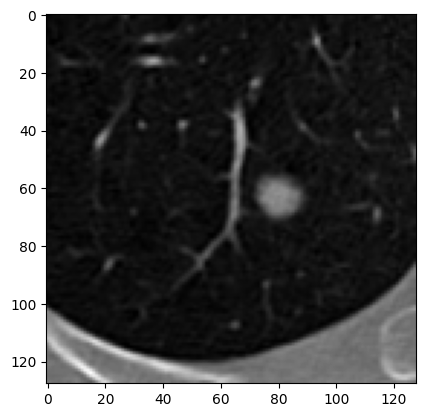

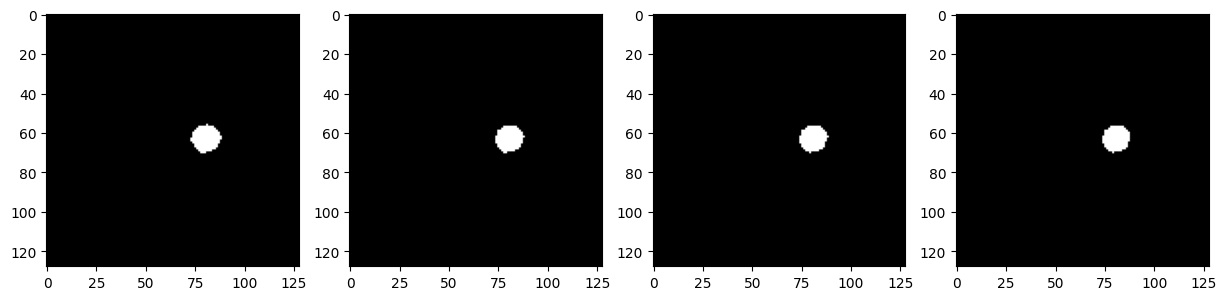

In [41]:
test_idx = 234
num_pred = 4

test_image = test_dataset[test_idx]
test_image = torch.unsqueeze(test_image, dim=0)
test_image = test_image.to(device)

test_preds = []

for _ in range(num_pred):
    test_mu_logvar = prior_net(test_image)
    test_mu = test_mu_logvar[:,:ZDIM]
    test_logvar = test_mu_logvar[:,ZDIM:]
    
    test_sigma = torch.sqrt(torch.exp(test_logvar))
    test_epsilon = torch.randn_like(test_sigma)
    test_z = test_mu + test_sigma * test_epsilon
    
    pred_mask = unet(test_image, test_z)
    pred_mask = torch.argmax(pred_mask, dim=1)
    test_preds.append(pred_mask)

test_image = torch.squeeze(test_image[0], dim=0).to("cpu")
plt.imshow(test_image, cmap='gray')
plt.show()

fig, axes = plt.subplots(1, num_pred, figsize=(15,5))
idx = 0
for test_pred in test_preds:
    test_pred = torch.squeeze(test_pred, dim=0).to("cpu")
    axes[idx].imshow(test_pred, cmap='gray')
    idx = idx+1
plt.show()

In [42]:
test_z.shape

torch.Size([1, 6])

In [43]:
test_preds[0].shape

torch.Size([1, 128, 128])